In [1]:
import clmm
from clmm import Cosmology
from clmm.support import mock_data as mock
from clmm.galaxycluster import GalaxyCluster
import matplotlib.pyplot as plt
import sys
import clmm.utils as u

/home/cdavies/.local/lib/python3.9/site-packages/clmm-1.0.1-py3.9.egg/clmm/theory/__init__.py:38: UserWarning: CLMM Backend requested `ccl' is not available, trying others...
/home/cdavies/.local/lib/python3.9/site-packages/clmm-1.0.1-py3.9.egg/clmm/theory/__init__.py:45: UserWarning: * USING NumCosmo BACKEND


Make sure we know which version we're using

In [2]:
clmm.__version__

'1.0.1'

### Define cosmology object

In [3]:
mock_cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)

First, we want to generate a $\Delta\Sigma$ (excess surface density) profile from mock data, to which we can apply boost factors. The mock data is generated in the following cells.

Generate cluster object from mock data

In [4]:
cosmo = mock_cosmo
cluster_id = "Awesome_cluster"
cluster_m = 1.e15
cluster_z = 0.3
concentration = 4
ngals = 1000

zsrc_min = cluster_z + 0.1 # we only want to draw background galaxies

noisy_data_z = mock.generate_galaxy_catalog(cluster_m,
                                            cluster_z,
                                            concentration,
                                            cosmo,
                                            'chang13',
                                            zsrc_min=zsrc_min,
                                            shapenoise=0.005,
                                            photoz_sigma_unscaled=0.05, ngals=ngals)

Loading this into a CLMM cluster object centered on (0,0)

In [5]:
cluster_ra = 0.0
cluster_dec = 0.0
cl = GalaxyCluster(cluster_id, cluster_ra, cluster_dec, 
                               cluster_z, noisy_data_z)

Compute cross and tangential excess surface density for each source galaxy

In [6]:
cl.compute_tangential_and_cross_components(geometry="flat",
                                                      shape_component1='e1', shape_component2='e2', 
                                                      tan_component='DeltaSigma_tan', cross_component='DeltaSigma_cross',
                                                      add=True, cosmo=cosmo, is_deltasigma=True)

(array([0.00263227, 0.0031391 , 0.00419572, 0.00205518, 0.00242369,
        0.00124051, 0.00045309, 0.00401413, 0.00162336, 0.00406274,
        0.00312606, 0.00293207, 0.00330852, 0.00434477, 0.00190194,
        0.00176117, 0.0043659 , 0.00259045, 0.00123287, 0.00186981,
        0.0021777 , 0.00236664, 0.00341277, 0.00317814, 0.00136671,
        0.00410323, 0.00496318, 0.00275999, 0.00445964, 0.00141611,
        0.00331436, 0.00140829, 0.00197146, 0.00350804, 0.002906  ,
        0.00451487, 0.00204659, 0.00263693, 0.00172278, 0.00157971,
        0.00387602, 0.00100764, 0.00158185, 0.00453614, 0.00249924,
        0.0054657 , 0.0043679 , 0.00465937, 0.00167372, 0.00224271,
        0.0041007 , 0.00353956, 0.00225956, 0.00321127, 0.00466017,
        0.00428761, 0.00189707, 0.00457333, 0.00435571, 0.00550272,
        0.00047158, 0.00315012, 0.00370137, 0.00193364, 0.00210016,
        0.00487417, 0.00526726, 0.0033493 , 0.00183135, 0.00569824,
        0.00347599, 0.00427441, 0.00360996, 0.00

Calculate the binned profile

In [7]:
cl.make_radial_profile("kpc", cosmo=cosmo, 
                       tan_component_in='DeltaSigma_tan', cross_component_in='DeltaSigma_cross',
                       tan_component_out='DeltaSigma_tan', cross_component_out='DeltaSigma_cross',
                       table_name='DeltaSigma_profile')
cl.DeltaSigma_profile.show_in_notebook()

idx,radius_min,radius,radius_max,DeltaSigma_tan,DeltaSigma_tan_err,DeltaSigma_cross,DeltaSigma_cross_err,z,z_err,n_src
0,129.6980758222127,446.14434466940065,671.0745349812448,199440850994129.84,11055830567940.19,-721417341572.4209,4225232676452.234,1.261544400742489,0.13579509138942777,21
1,671.0745349812448,958.1076293891728,1212.450994140277,121669945514041.7,7726399342325.708,3636170917607.385,3978188778088.902,1.3199220107786458,0.11510326662255983,44
2,1212.450994140277,1484.7519845764455,1753.8274532993094,79073557732054.56,2754805469691.5557,-891823862167.7793,1987413415420.6985,1.3710301831570317,0.08796085405106875,76
3,1753.8274532993094,2028.4262381403912,2295.203912458341,56278866619043.42,1705797634396.6335,1957571292380.75,1709893346062.838,1.2580165384463016,0.07635386099061975,111
4,2295.203912458341,2552.705991434152,2836.580371617373,43320643754893.914,1433785223685.1838,-1088932940854.3564,1404000418034.6287,1.2350952604177416,0.06495169534819462,115
5,2836.580371617373,3098.551475177629,3377.9568307764057,35199681980220.5,1653069354495.0205,-2529332023492.7593,1242734152333.685,1.2490581996607726,0.05354982506390606,159
6,3377.9568307764057,3663.322753135045,3919.3332899354377,29256372999874.887,1102887688620.4287,-935994627416.8568,1027733325146.5746,1.3052392202961376,0.04981407886376973,206
7,3919.3332899354377,4135.318785001795,4460.70974909447,24932520641962.246,1170830212962.7083,80170015796.4321,1201108282827.7554,1.2332344353112283,0.04644407966003468,163
8,4460.70974909447,4702.337876829513,5002.086208253502,21581854108597.047,1947884298688.947,-1368781419250.8713,2406055829082.849,1.2202483036000407,0.06903561435678433,72
9,5002.086208253502,5226.420465897965,5543.462667412534,14983910479060.338,3032971249650.221,-5505038412651.513,2778358825719.815,1.308231342571678,0.1248602792130765,33


Plot the $\Delta\Sigma$ profile

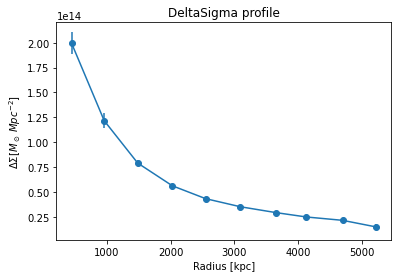

In [8]:
plt.errorbar(cl.DeltaSigma_profile['radius'], cl.DeltaSigma_profile['DeltaSigma_tan'],
             cl.DeltaSigma_profile['DeltaSigma_tan_err'], marker = 'o')
plt.title('DeltaSigma profile')
plt.xlabel("Radius [kpc]")
plt.ylabel('$\Delta\Sigma [M_\odot\; Mpc^{-2}]$')
plt.show()

## Boost Factors

CLMM offers two boost models, the NFW boost model, and a powerlaw boost model. 

Note that `compute_nfw_boost` requires two parameters to be specified, `rs` and `b0`, and `compute_powerlaw_boost` requires three paramters, `rs`, `b0` and `alpha`. The default values are in kpc. 

Details on these boost models can be found [here](https://cluster-toolkit.readthedocs.io/en/latest/source/boostfactors.html)

First, we can calculate the boost factors from the two models.

In [9]:
nfw_boost = u.compute_nfw_boost(cl.DeltaSigma_profile['radius'],rs=1000, b0=0.1)

powerlaw_boost = u.compute_powerlaw_boost(cl.DeltaSigma_profile['radius'],rs=1000, b0=0.1, alpha=-1.0)

Plot the two boost factors, $B(R)$

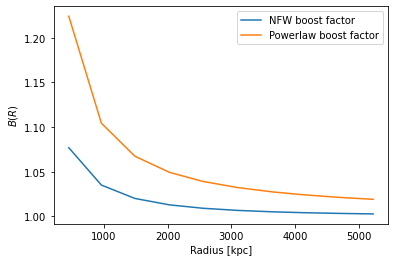

In [11]:
plt.plot(cl.DeltaSigma_profile['radius'],nfw_boost,label='NFW boost factor')
plt.plot(cl.DeltaSigma_profile['radius'],powerlaw_boost,label='Powerlaw boost factor')
plt.xlabel("Radius [kpc]")
plt.ylabel("$B(R)$")
plt.legend()
plt.show()

The $\Delta\Sigma$ profiles can be corrected with the boost factor using `correct_sigma_with_boost_values` or `correct_sigma_with_boost_model`. 

`correct_sigma_with_boost_values` requires us to precompute the boost factor, e.g. using `compute_nfw_boost`.
`correct_sigma_with_boost_model` simply requires us to specify the boody model.

First we will apply the boost factor with `correct_sigma_with_boost_values`

In [12]:
#nfw_boost = u.compute_nfw_boost(cl.DeltaSigma_profile['radius'],rs=1000, b0=0.1)

#powerlaw_boost = u.compute_powerlaw_boost(cl.DeltaSigma_profile['radius'],rs=1000, b0=0.1, alpha=-1.0)

#We would usually have to precompute the boost factors one of the above lines of code 
#but this has already been done in a previous cell

Sigma_corrected_powerlaw_boost = u.correct_sigma_with_boost_values(cl.DeltaSigma_profile['radius'],
                                                                   cl.DeltaSigma_profile['DeltaSigma_tan'],
                                                                   powerlaw_boost)
Sigma_corrected_nfw_boost = u.correct_sigma_with_boost_values(cl.DeltaSigma_profile['radius'],
                                                              cl.DeltaSigma_profile['DeltaSigma_tan'],
                                                              nfw_boost)

Plot the result

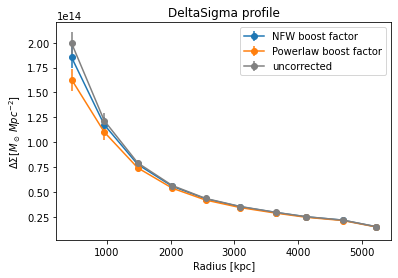

In [13]:
plt.errorbar(cl.DeltaSigma_profile['radius'], Sigma_corrected_nfw_boost,
             cl.DeltaSigma_profile['DeltaSigma_tan_err'], marker = 'o',label='NFW boost factor')

plt.errorbar(cl.DeltaSigma_profile['radius'], Sigma_corrected_powerlaw_boost,
             cl.DeltaSigma_profile['DeltaSigma_tan_err'], marker = 'o',label='Powerlaw boost factor')

plt.errorbar(cl.DeltaSigma_profile['radius'], cl.DeltaSigma_profile['DeltaSigma_tan'],
             cl.DeltaSigma_profile['DeltaSigma_tan_err'], marker = 'o',label='uncorrected',color='grey')

#plt.loglog()
plt.title('DeltaSigma profile')
plt.xlabel("Radius [kpc]")
plt.ylabel('$\Delta\Sigma [M_\odot\; Mpc^{-2}]$')
plt.legend()
plt.show()

Now the same again but with `correct_sigma_with_boost_model`

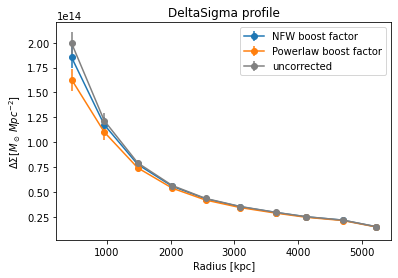

In [14]:
Sigma_corrected_powerlaw_boost = u.correct_sigma_with_boost_model(cl.DeltaSigma_profile['radius'],
                                                                   cl.DeltaSigma_profile['DeltaSigma_tan'],
                                                                   boost_model='powerlaw_boost')
Sigma_corrected_nfw_boost = u.correct_sigma_with_boost_model(cl.DeltaSigma_profile['radius'],
                                                              cl.DeltaSigma_profile['DeltaSigma_tan'],
                                                              boost_model='nfw_boost')

plt.errorbar(cl.DeltaSigma_profile['radius'], Sigma_corrected_nfw_boost,
             cl.DeltaSigma_profile['DeltaSigma_tan_err'], marker = 'o',label='NFW boost factor')

plt.errorbar(cl.DeltaSigma_profile['radius'], Sigma_corrected_powerlaw_boost,
             cl.DeltaSigma_profile['DeltaSigma_tan_err'], marker = 'o',label='Powerlaw boost factor')

plt.errorbar(cl.DeltaSigma_profile['radius'], cl.DeltaSigma_profile['DeltaSigma_tan'],
             cl.DeltaSigma_profile['DeltaSigma_tan_err'], marker = 'o',label='uncorrected',color='grey')

#plt.loglog()
plt.title('DeltaSigma profile')
plt.xlabel("Radius [kpc]")
plt.ylabel('$\Delta\Sigma [M_\odot\; Mpc^{-2}]$')
plt.legend()
plt.show()